# `giskard-vision` Report for Facial Landmark Detection 

#### Import the needed libraries

In [ ]:
from face_alignment import FaceAlignment, LandmarksType

from giskard_vision.landmark_detection.dataloaders.loaders import DataLoader300W
from giskard_vision.landmark_detection.dataloaders.wrappers import (
    CroppedDataLoader,
    ResizedDataLoader,
    HeadPoseDataLoader,
    EthnicityDataLoader,
)
from giskard_vision.core.dataloaders.wrappers import (
    CachedDataLoader,
    FilteredDataLoader,
    ColoredDataLoader,
    BlurredDataLoader,
)

from giskard_vision.landmark_detection.models.wrappers import OpenCVWrapper, FaceAlignmentWrapper
from giskard_vision.landmark_detection.marks.facial_parts import FacialParts
from giskard_vision.landmark_detection.tests.report import Report
from giskard_vision.landmark_detection.visualisation.draw import draw_marks

#### Load the main dataset

In [ ]:
dl_ref = DataLoader300W(dir_path="../datasets/300W/sample")

#### Define your criteria

In [ ]:
# cropping
dl_cropped_left = CroppedDataLoader(dl_ref, part=FacialParts.LEFT_HALF.value)
dl_cropped_upper = CroppedDataLoader(dl_ref, part=FacialParts.UPPER_HALF.value)

# resizing
dl_resized = ResizedDataLoader(dl_ref, scales=0.5)

# coloring
dl_colored = ColoredDataLoader(dl_ref)

# blurring
dl_blurred = BlurredDataLoader(dl_ref)


# head pose filtering
def positive_roll(elt):
    return elt[2]["headPose"]["roll"] > 0


def negative_roll(elt):
    return elt[2]["headPose"]["roll"] < 0


cached_dl = CachedDataLoader(HeadPoseDataLoader(dl_ref), cache_size=None, cache_img=False, cache_labels=False)
dl_positive_roll = FilteredDataLoader(cached_dl, positive_roll)
dl_negative_roll = FilteredDataLoader(cached_dl, negative_roll)


# ethnicity filtering
def white_ethnicity(elt):
    return elt[2]["ethnicity"] == "white"


def latino_ethnicity(elt):
    return elt[2]["ethnicity"] == "latino hispanic"


cached_dl = CachedDataLoader(
    EthnicityDataLoader(dl_ref, ethnicity_map={"indian": "asian"}), cache_size=None, cache_img=False, cache_labels=False
)
dl_white = FilteredDataLoader(cached_dl, white_ethnicity)
dl_latino = FilteredDataLoader(cached_dl, latino_ethnicity)

dataloaders_list = [
    dl_cropped_left,
    dl_cropped_upper,
    dl_colored,
    dl_blurred,
    dl_resized,
    dl_positive_roll,
    dl_negative_roll,
    dl_white,
    dl_latino,
]

#### Examples

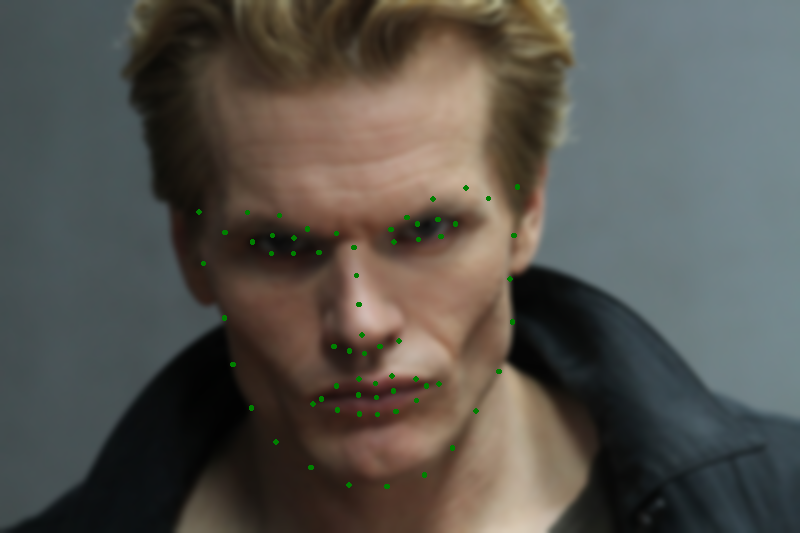

In [18]:
image, ground_truth_landmarks, meta = dl_blurred[1]
draw_marks(image[0], [ground_truth_landmarks], ["green"])

#### Initialise the models you'd like to compare

In [ ]:
models_list = [
    FaceAlignmentWrapper(model=FaceAlignment(LandmarksType.TWO_D, device="cpu", flip_input=False)),
    OpenCVWrapper(),
]

#### Create the report

In [ ]:
report = Report(models_list, dataloaders_list, dataloader_ref=dl_ref)

#### Convert the report into a dataframe

In [19]:
report.to_dataframe()

,criteria,model,test,metric,metric_value,Best(metric_value),prediction_time,Best(prediction_time),prediction_fail_rate,Best(prediction_fail_rate)
0,altered color,FaceAlignment,TestDiff,NME_mean,0.006728,,9.276386,,0.000000,✓
1,altered color,OpenCV,TestDiff,NME_mean,-0.001347,✓,0.448969,✓,0.000000,
2,blurred,FaceAlignment,TestDiff,NME_mean,0.009508,✓,9.149766,,0.000000,✓
3,blurred,OpenCV,TestDiff,NME_mean,0.103017,,0.416969,✓,0.000000,
4,cropped on left half,FaceAlignment,TestDiff,NME_mean,0.656253,,11.104118,,0.673529,✓
5,cropped on left half,OpenCV,TestDiff,NME_mean,0.644057,✓,0.355286,✓,0.673529,
6,cropped on upper half,FaceAlignment,TestDiff,NME_mean,0.223175,,8.941763,,0.470588,✓
7,cropped on upper half,OpenCV,TestDiff,NME_mean,-0.040216,✓,0.363663,✓,0.894118,
8,latino_ethnicity,FaceAlignment,TestDiff,NME_mean,0.208285,✓,5.293747,,0.000000,✓
9,latino_ethnicity,OpenCV,TestDiff,NME_mean,0.784538,,0.266132,✓,0.000000,


In [20]:
report.to_dataframe(summary=True)

Best(prediction_time)         \
model                            FaceAlignment OpenCV   
criteria                                                
altered color                                       ✓   
blurred                                             ✓   
cropped on left half                                ✓   
cropped on upper half                               ✓   
latino_ethnicity                                    ✓   
negative_roll                                       ✓   
positive_roll                                       ✓   
resized with ratios: 0.5                            ✓   
white_ethnicity                                     ✓   

                         Best(prediction_fail_rate)        Best(metric_value)  \
model                                 FaceAlignment OpenCV      FaceAlignment   
criteria                                                                        
altered color                                     ✓                             
blurred                                           ✓                         ✓   
cropped on left half                              ✓                             
cropped on upper half                             ✓                             
latino_ethnicity                                  ✓                         ✓   
negative_roll                                     ✓                             
positive_roll                                     ✓                         ✓   
resized with ratios: 0.5                          ✓                         ✓   
white_ethnicity                                   ✓                             

                                 
model                    OpenCV  
criteria                         
altered color                 ✓  
blurred                          
cropped on left half          ✓  
cropped on upper half         ✓  
latino_ethnicity                 
negative_roll                 ✓  
positive_roll                    
resized with ratios: 0.5         
white_ethnicity               ✓